In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage

from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

import skfda
from skfda.ml.clustering import FuzzyCMeans

c:\Users\bkran\miniconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Cluster Analysis: To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

Data Preparations for the Clustering

In [2]:
input_data = pd.read_csv("./charging_cleaned.csv")

# determining the total amount of seconds spent on the charging station
time_in = input_data["connectionTime"]
time_out = input_data["disconnectTime"]

# time on charging station while not charging
time_w = input_data["doneChargingTime"]
time_w = pd.to_datetime(time_w)

time_in = pd.to_datetime(time_in)
time_out = pd.to_datetime(time_out)

time_all = time_out - time_in

#time_all.to_csv("./time_total.csv")

time_sec = np.zeros(time_all.size)

for i in range(time_all.size):
   time_sec[i] = int(time_all[i].total_seconds())


KWh = input_data["kWhDelivered"]

time_charging = time_w - time_in

time_charging_sec = np.zeros(time_charging.size)

for i in range(time_charging.size):
   time_charging_sec[i] = int(time_charging[i].total_seconds())

# preparing the siteId
site_Id = input_data["siteID"]

# preparing the datamatches from input and overall?
matches = input_data["date_matches"]


In [3]:
# Total time in minutes rounded down to minutes
year_in = time_in.dt.year
year_out = time_out.dt.year
year_w = time_w.dt.year

# preparing the months just using the connectiontime
month_in = time_in.dt.month 
month_out = time_out.dt.month 
month_w = time_w.dt.month 

# preparing the days just using the connectiontime
days_in = time_in.dt.day 
day_year_in = time_in.dt.day_of_year

days_our = time_out.dt.day 
day_year_out = time_out.dt.day_of_year

days_w = time_w.dt.day 
day_year_w = time_w.dt.day_of_year

# minute of the hour
minute_in = time_in.dt.minute
minute_out = time_out.dt.minute
minute_w = time_w.dt.minute

# time of the day
time_of_day_in = time_in.dt.hour 
time_of_day_out = time_out.dt.hour 
time_of_day_w = time_w.dt.hour 

time_in_min =  time_of_day_in + minute_in / 60 

time_out_min =  time_of_day_out  + minute_out / 60 

time_w_min =  time_of_day_w  + minute_w / 60 

In [4]:
# All of the data from the user inputs, to see if there is a difference, userInputs_WhPerMile, userInputs_kWhRequested, userInputs_milesRequested, userInputs_minutesAvailable, userInputs_modifiedAt, userInputs_paymentRequired,  userInputs_requestedDeparture
# determining the total amount of seconds spent on the charging station
time_all_user = input_data["userInputs_minutesAvailable"]

KWh_user = input_data["userInputs_kWhRequested"]

# userInputs_WhPerMile
Wh_per_mile_user = input_data["userInputs_WhPerMile"]

# userInputs_milesRequested 
miles_req = input_data["userInputs_milesRequested"]

# userInputs_modifiedAt
mod_at = input_data["userInputs_modifiedAt"]

# userInputs_paymentRequired
pay_req = input_data["userInputs_paymentRequired"]

# userInputs_requestedDeparture
req_dep = input_data["userInputs_requestedDeparture"]

K-Means Clustering

In [6]:
# putting data in dataframe connectionTime (time_in), disconnectTime (time_out), doneChargingTime (time_w), kWhDelivered (KWh), kWhRequested (KWh_user), milesRequested (miles_req), minutesAvailable (time_all_user)
data_clustering = pd.DataFrame()
data_clustering["connectionTime"] = time_in_min
data_clustering["diconnectionTime"] = time_out_min
data_clustering["doneChargingTime"] = time_w_min
data_clustering["kWhDelivered"] = KWh
data_clustering["minutesAvailable"] = time_all_user
data_clustering["milesRequested"] = miles_req
data_clustering["kWhRequested"] = KWh_user

In [7]:
# scaling the data, not sure if i need that
  
X = data_clustering

scaler = StandardScaler()
scaler.fit(data_clustering)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=data_clustering.columns, index=data_clustering.index)
X_scaled_df.head()

data_clustering_s = X_scaled_df

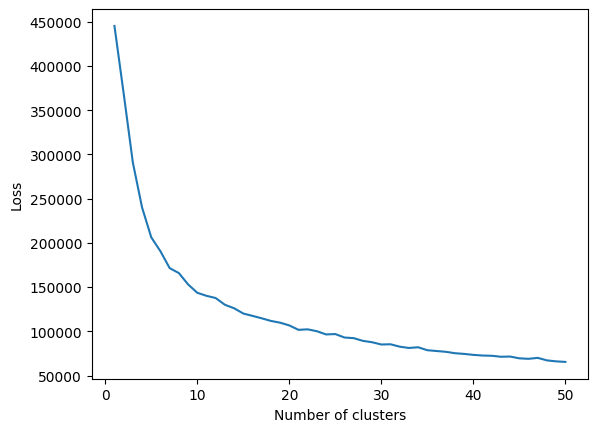

In [34]:
# Clustering using the things from the lecture https://github.com/IS3UniCologne/AA_2024/blob/main/Workshop_10/AA_WS_10_Clustering.ipynb
# Clustering of the connectionTime (time_in), disconnectTime (time_out), doneChargingTime (time_w), kWhDelivered (KWh), kWhRequested (KWh_user), milesRequested (miles_req), minutesAvailable (time_all_user), 
# Kmeans of all of the values

k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)


plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 10.0)

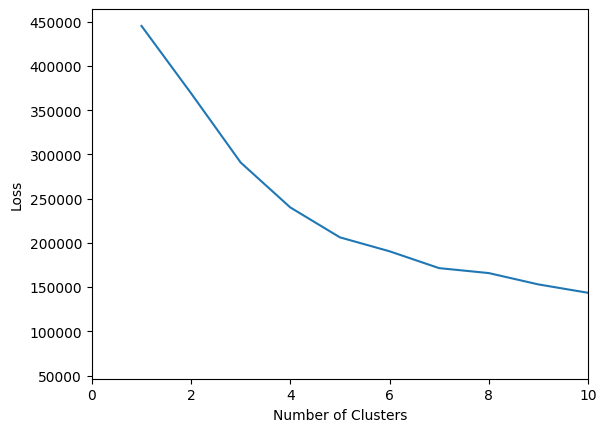

In [35]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of Clusters")
plt.xlim([0,10])

In [ ]:
# refit algorithm
two_means = KMeans(n_clusters=4, n_init='auto')
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([2, 1, 2, ..., 0, 0, 0])

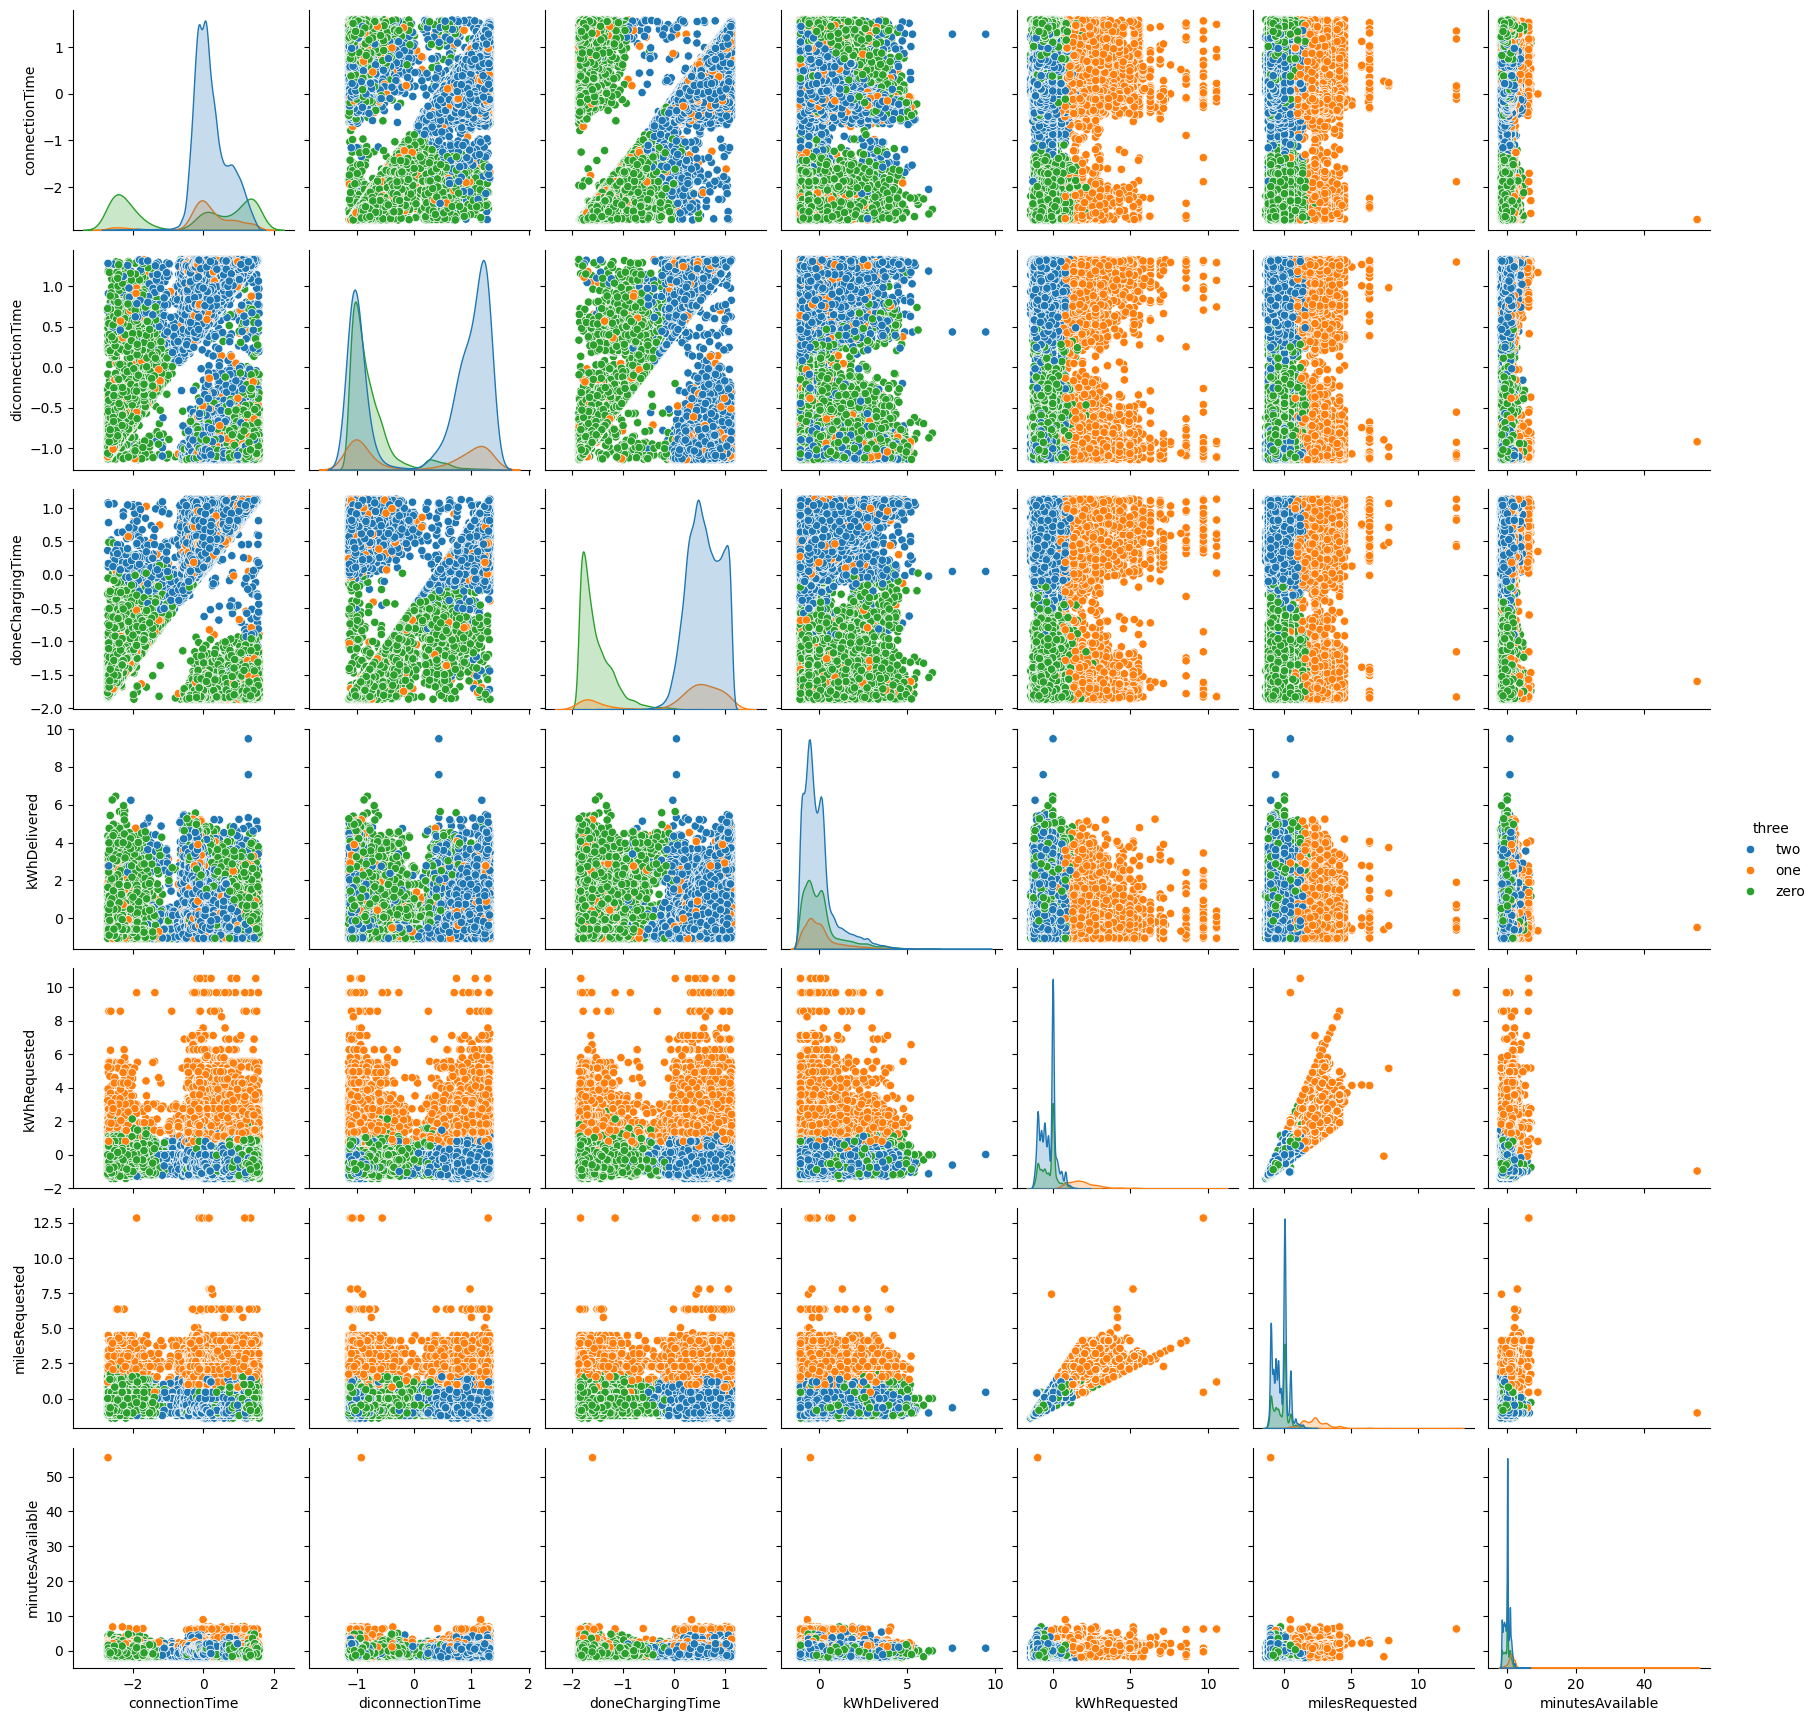

In [ ]:
numbers = ["zero", "one", "two", "three", "four"] 

data_clustering_s["four"] = two_means.predict(X_scaled)
data_clustering_s["four"] = data_clustering_s["four"].apply(lambda x: numbers[x])
sns.pairplot(data=data_clustering_s, hue="four")


data_clustering_s["three"] = two_means.predict(X_scaled)
data_clustering_s["three"] = data_clustering_s["three"].apply(lambda x: numbers[x])
sns.pairplot(data=data_clustering_s, hue="three")

Clustering of the weather in combination with the data

In [18]:
# connectionTime (time_in), disconnectTime (time_out), doneChargingTime (time_w), kWhDelivered (KWh), kWhRequested (KWh_user), milesRequested (miles_req), minutesAvailable (time_all_user), Agglomerative Clustering

KeyError: -7454

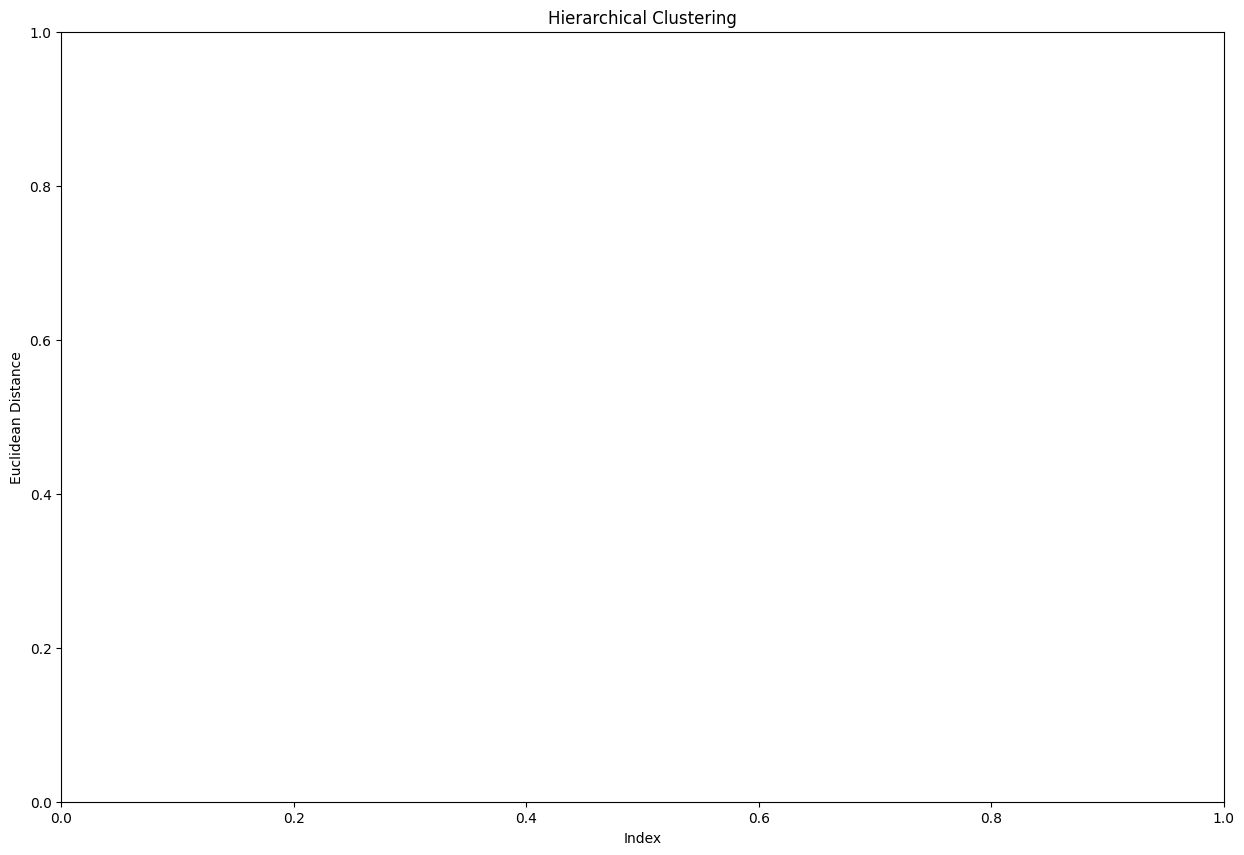

In [44]:
# A slightly different way of hierarchical clustering

plt.figure(figsize=(15, 10))  
plt.title("Hierarchical Clustering")  
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')
dendrogram(linkage(X_scaled, method='ward', ))

In [21]:
#iris["Agglo"] = y_pred_agglo

#fig, ax = plt.subplots(1,2, figsize=(9,5))
#sns.scatterplot(ax=ax[0], x="Sepal.Length", y="Petal.Width", data=iris, hue="Agglo")
#sns.scatterplot(ax=ax[1], x="Sepal.Length", y="Petal.Width", hue="Species", data=iris)

<Axes: >

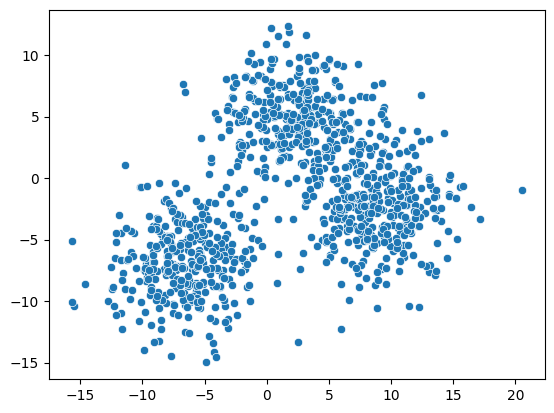

In [22]:
# Soft Clustering similar to the lecture
N = 1000
C = 3

X, y_true = make_blobs(n_samples=N, centers=C, cluster_std=3, random_state=42)
X = X[:, ::-1]

sns.scatterplot(x=X[:,0], y=X[:,1])

In [23]:
X_f = skfda.FDataGrid(X)

fuzzy_model = FuzzyCMeans(n_clusters=3, fuzzifier = 2)
cluster = fuzzy_model.fit_predict(X_f)

U = fuzzy_model.membership_degree_
U_max = np.max(U, axis=1)

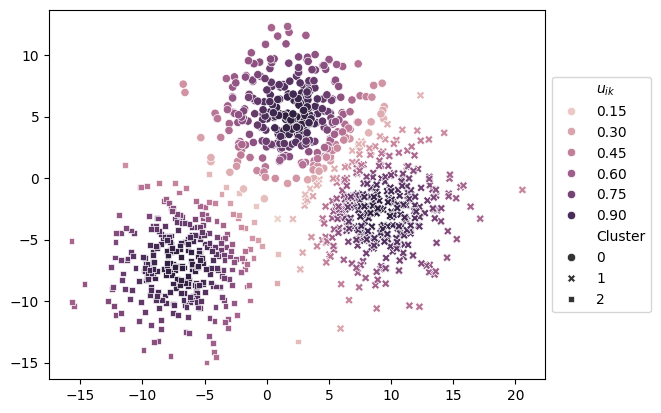

In [24]:
ax = sns.scatterplot(
    x=X[:,0], 
    y=X[:,1], 
    style=pd.Series(cluster, name='Cluster'), 
    hue=pd.Series(U_max**2, name='$u_{ik}$')
)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

The same clustering strategies as above with sampled data instead of the full data

In [49]:
# Sampling the data
data_sampled = data_clustering.sample(n=2_500, random_state=42)

In [26]:
# scaling the data, not sure if i need that
  
X_sampled = data_sampled

scaler = StandardScaler()
scaler.fit(data_clustering)
X_scaled_sam = scaler.transform(X_sampled)
X_scaled_sam_df = pd.DataFrame(X_scaled_sam, columns=data_sampled.columns, index=data_sampled.index)
X_scaled_sam_df.head()

data_clustering_sam = X_scaled_sam_df

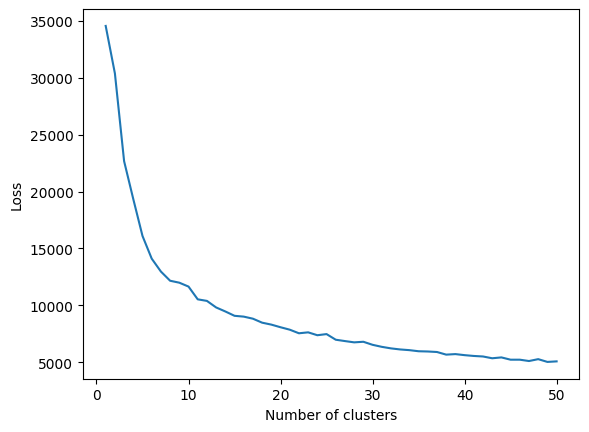

In [27]:
# Clustering using the things from the lecture https://github.com/IS3UniCologne/AA_2024/blob/main/Workshop_10/AA_WS_10_Clustering.ipynb
# Clustering of the connectionTime (time_in), disconnectTime (time_out), doneChargingTime (time_w), kWhDelivered (KWh), kWhRequested (KWh_user), milesRequested (miles_req), minutesAvailable (time_all_user), 
# Kmeans of all of the values

k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled_sam)
    clusters.append(k+1)
    losses.append(model.inertia_)


plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 10.0)

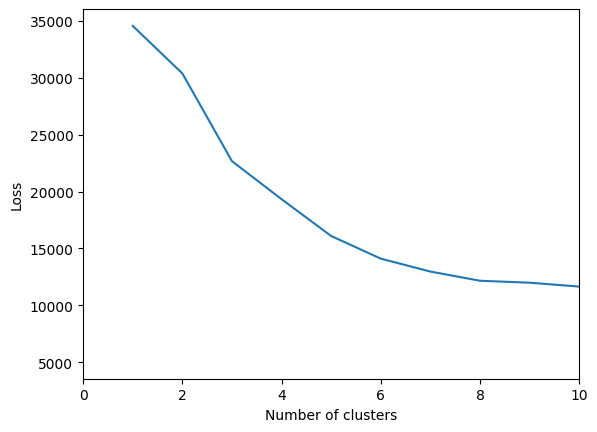

In [28]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

In [29]:
# refit algorithm
two_means_sam = KMeans(n_clusters=3, n_init='auto')
two_means_sam.fit(X_scaled_sam)

# match records to clusters by calling predict
two_means_sam.predict(X_scaled_sam)

array([1, 2, 2, ..., 0, 0, 0])

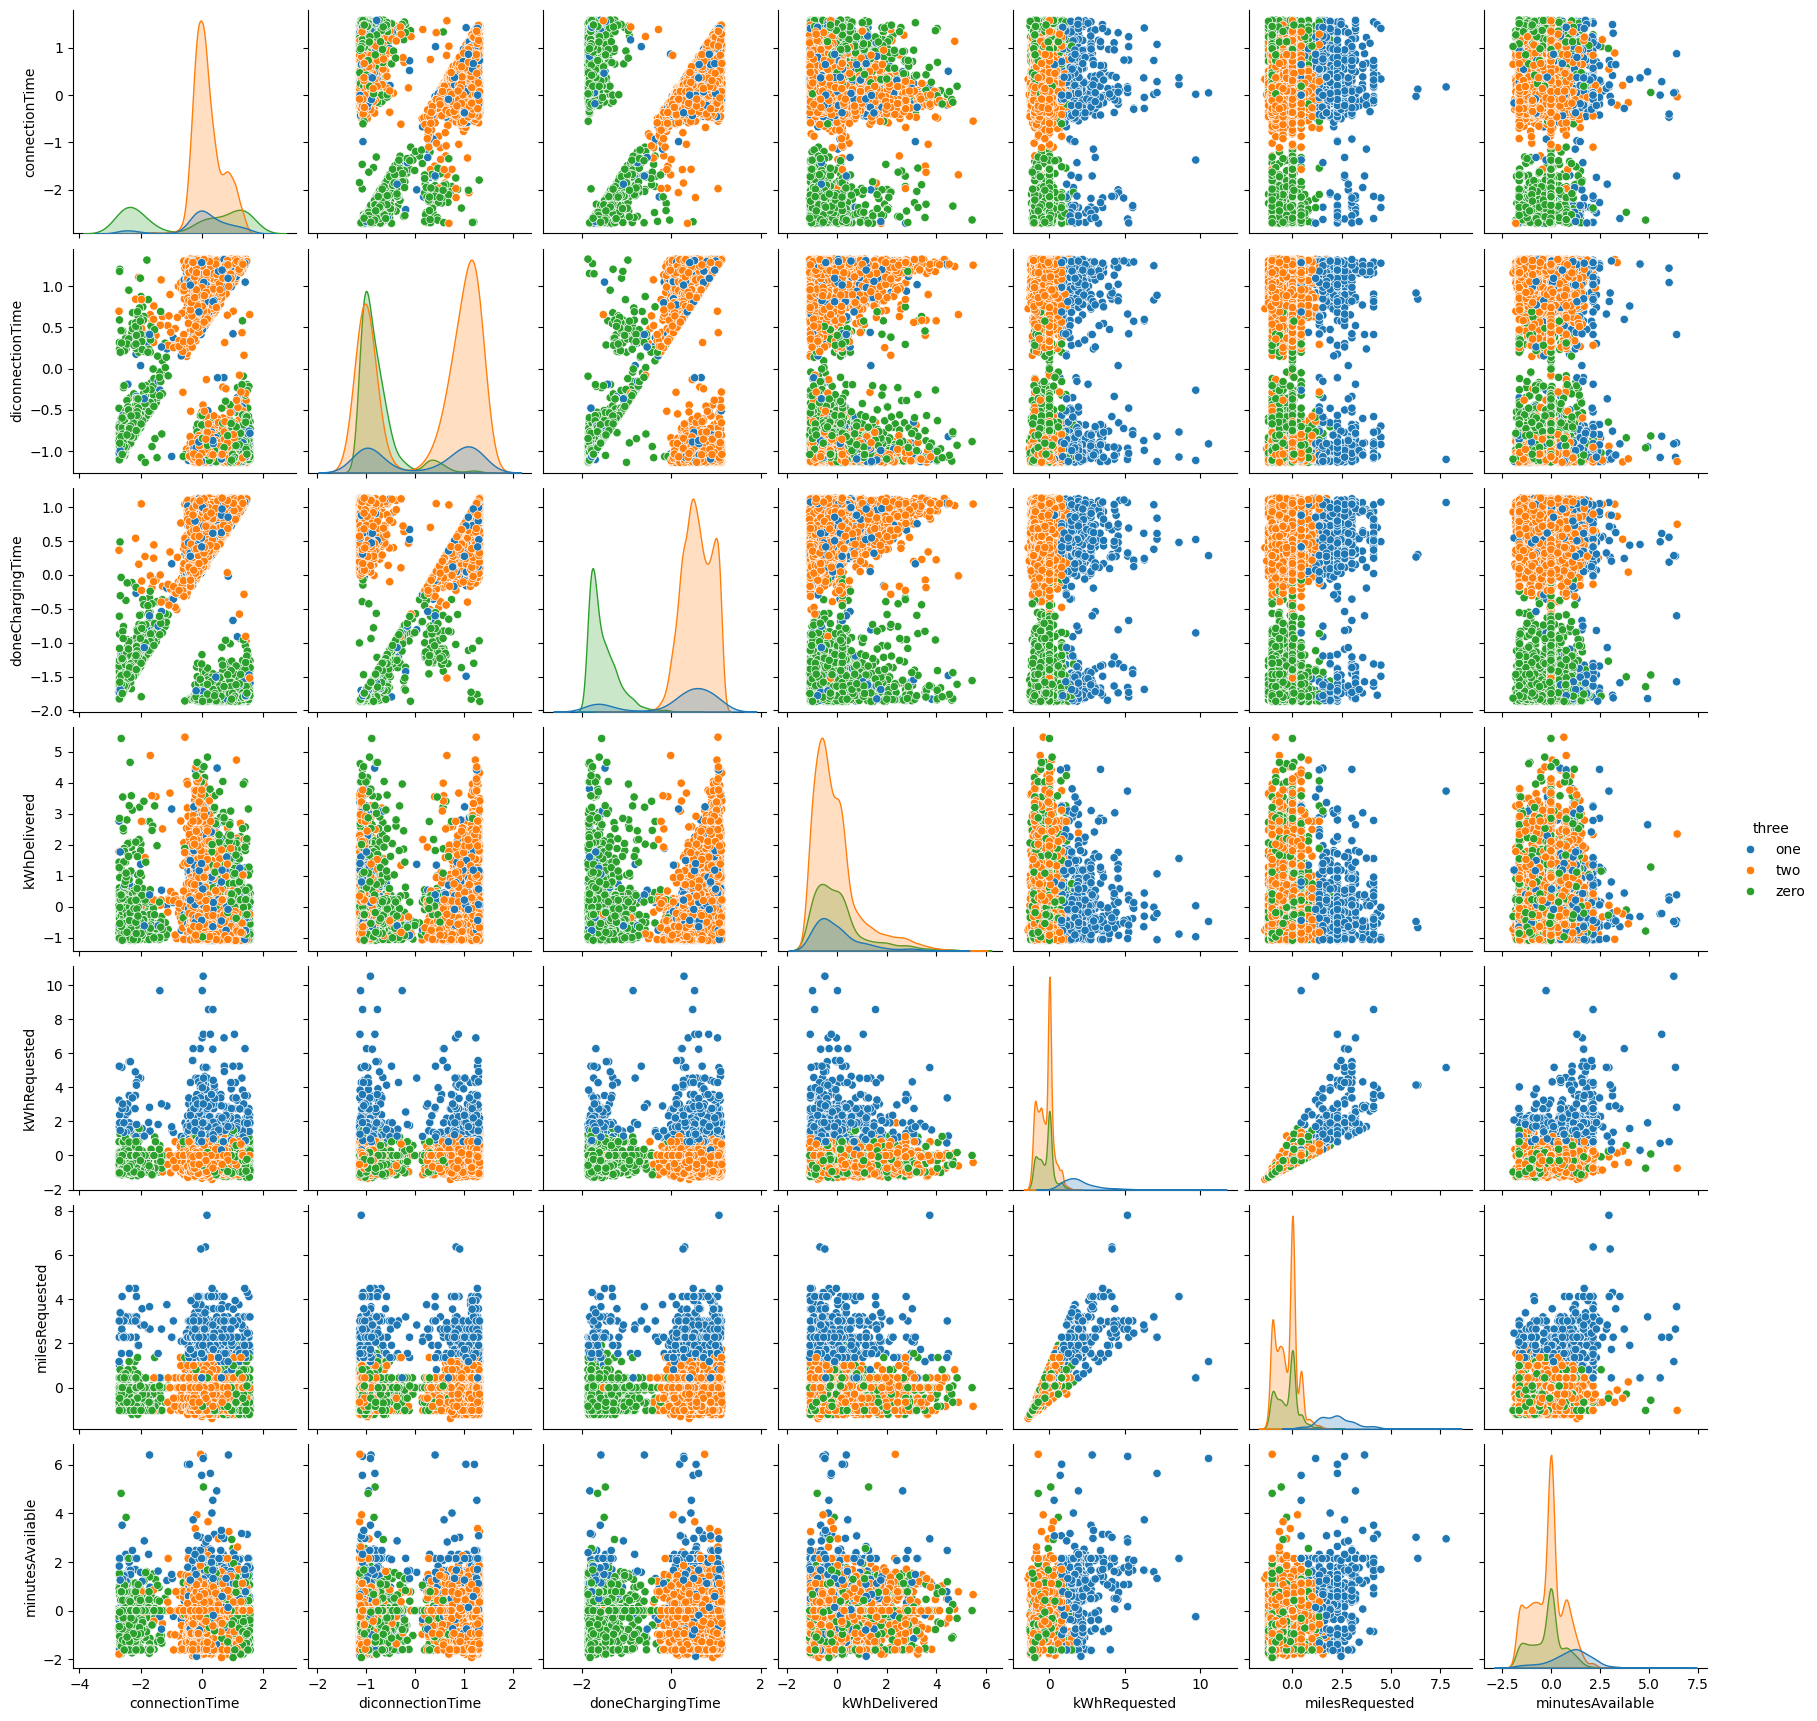

In [30]:
numbers = ["zero", "one", "two", "three"] 

data_clustering_sam["three"] = two_means_sam.predict(X_scaled_sam)
data_clustering_sam["three"] = data_clustering_sam["three"].apply(lambda x: numbers[x])
sns.pairplot(data=data_clustering_sam, hue="three")

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [12.5, 12.5, 40.0, 40.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [26.25, 26.25, 62.5, 62.5],
  [85.0, 85.0, 95.0, 95.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [105.0, 105.0, 122.5, 122.5],
  [145.0, 145.0, 155.0, 155.0],
  [113.75, 113.75, 150.0, 150.0],
  [90.0, 90.0, 131.875, 131.875],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [200.0, 200.0, 230.0, 230.0],
  [172.5, 172.5, 215.0, 215.0],
  [110.9375, 110.9375, 193.75, 193.75],
  [44.375, 44.375, 152.34375, 152.34375],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [285.0, 285.0, 295.0, 295.0],
  [262.5, 262.5, 290.0, 290.0],
  [305.0, 305.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [310.0, 310.0, 330.0, 330.0],
  [355.0

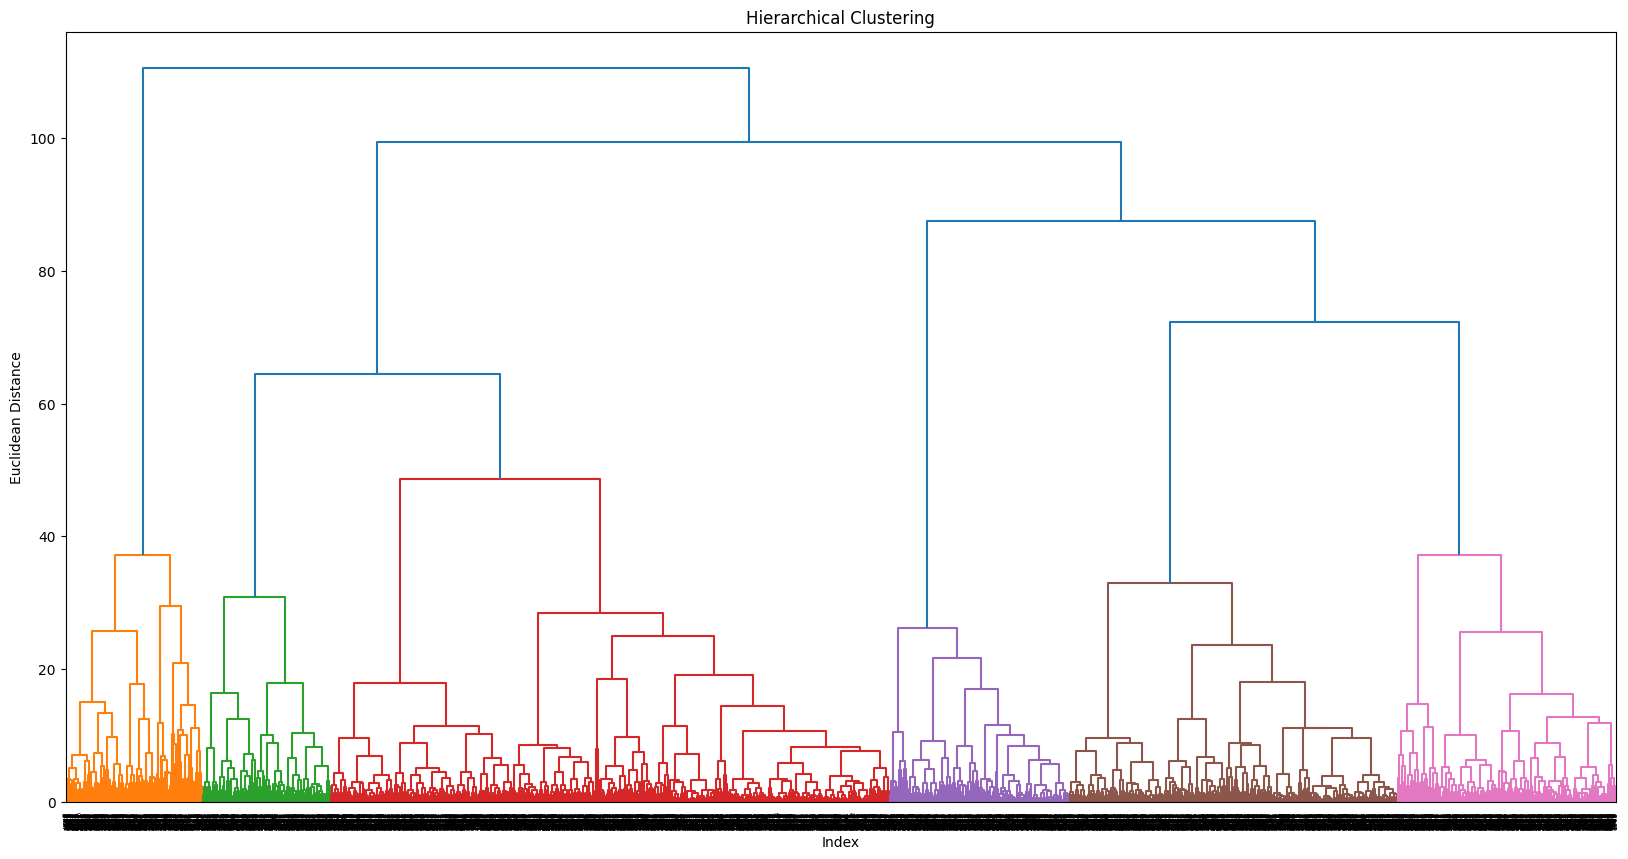

In [48]:
# A slightly different wy of hierarchical clustering

plt.figure(figsize=(20, 10))  
plt.title("Hierarchical Clustering")  
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')
dendrogram(linkage(X_scaled_sam, method='ward', ), color_threshold=51)

In [ ]:
'''data = list(zip(time_sec, KWh, time_charging_sec))
it = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    it.append(kmeans.inertia_)

plt.plot(range(1,11), it, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inerations')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
it.append(kmeans.inertia_)

plt.scatter(time_sec, KWh, c=kmeans.labels_)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 


plt.scatter(time_sec, KWh, c=site_Id)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 

plt.scatter(time_sec, time_charging_sec, c=kmeans.labels_)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 


plt.scatter(time_sec, time_charging_sec, c=site_Id)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 

plt.scatter(time_charging_sec, KWh, c=kmeans.labels_)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 


plt.scatter(time_charging_sec, KWh, c=site_Id)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() 
'''

In [ ]:
'''# Clustering including the energy and if it was fully charged or not, did different tries with combination of (KWh, perc_charged, time_perc) -> did not find useful graphic
data = list(zip(KWh, time_sec, month_in))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

plt.scatter(KWh, time_sec, c=kmeans.labels_)
plt.show() 

#ax = plt.axes(projection='3d')

# time_perc is the time used in percent
#ax.scatter3D(time_perc, time_perc, KWh,c=kmeans.labels_) '''

In [ ]:
# Hierachical Clustering
'''
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3) #The number of clusters to find
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()

'''

In [ ]:
'''# Clustering of the user defined data to see if the same phenomenome happens as with the official data with the same 2 datapoints, time and energy
data = list(zip(time_all_user, KWh_user))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
inertias.append(kmeans.inertia_)
plt.xlabel("From User requested Energy in kWh")
plt.ylabel("Requested Time in Minutes")
plt.scatter(time_all_user, KWh_user, c=kmeans.labels_)
plt.show() 

plt.scatter(time_all_user, KWh_user, c=site_Id)
plt.xlabel("Energy in kWh")
plt.ylabel("Time in Seconds")
plt.show() '''

In [ ]:
'''
# data from the user as a 3d plot same as the second plot
data = list(zip(KWh, time_perc, perc_charged))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')

# time_perc is the time used in percent
ax.scatter3D(KWh, time_perc, time_perc,c=kmeans.labels_)
'''

In [ ]:
'''# data of weather from the merging file 
weather = pd.read_csv("../Tasks/weather_cleaned.csv", encoding="ISO-8859-1")
charging = pd.read_csv("../Tasks/charging_cleaned.csv", encoding="ISO-8859-1")

charging['connectionTime'] = pd.to_datetime(charging['connectionTime'], utc=True)
weather['timestamp'] = pd.to_datetime(weather['timestamp'], utc=True)

charging['hour'] = charging['connectionTime'].dt.floor('h')

weather['hour'] = weather['timestamp'].dt.floor('h')

merged_data = pd.merge(
    charging,
    weather[['hour', 'temperature']], 
    on='hour', 
    how='inner'
)
'''

In [ ]:
'''# Preparing data for Clustering 
temp = merged_data["temperature"]

time_in_w = merged_data["connectionTime"]
time_out_w = merged_data["disconnectTime"]

time_in_w = pd.to_datetime(time_in_w)
time_out_w = pd.to_datetime(time_out_w)

time_all_w = time_out_w - time_in_w

time_sec_weather = np.zeros(time_all_w.size)

for i in range(time_all_w.size):
   time_sec_weather[i] = int(time_all_w[i].total_seconds())


# energy weather
kHw_w = merged_data["kWhDelivered"]

# site ID
weather_site_id = merged_data["siteID"]
'''

In [ ]:
'''# Kmeans with weather using time charged temperature and energy
data = list(zip(temp, kHw_w, time_sec_weather))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')
ax.scatter3D(kHw_w, time_sec_weather, temp, c=kmeans.labels_)


#axe = plt.axes(projection='3d')
#axe.scatter3D(kHw_w, time_sec_weather, temp, c=weather_site_id)
'''